In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
# Obtendo o diretório atual do Jupyter Notebook
caminho_script = "\\".join(os.getcwd().split("\\")[:-1])
print("Caminho do diretório atual:", caminho_script)
# Adicionando o diretório ao sys.path se precisar importar módulos
sys.path.append(caminho_script)
from IPython.display import clear_output

from classes.dados.dados import DataHandler as dh
from classes.dados.GaussianData import GausianDataHandler as gdh
from classes.dados.monteCarlo import MonteCarlo as MC
from classes.modelos.GausianCov import GaussianCovModel as GCM
from classes.modelos.GausianTrad import GausianTraditionalModel as GTM
from classes.modelos.GausianGreg import GausianGredModel as GGM
from classes.modelos.GausFriedman import GausianFriedman as GFM
from classes.modelos.MQOtradicional import MQOT
from classes.modelos.GausNaiveBay import GausNaiveBay as GNB

Caminho do diretório atual: c:\Users\Igor8\OneDrive\Área de Trabalho\Classificacao


## Plotar dados

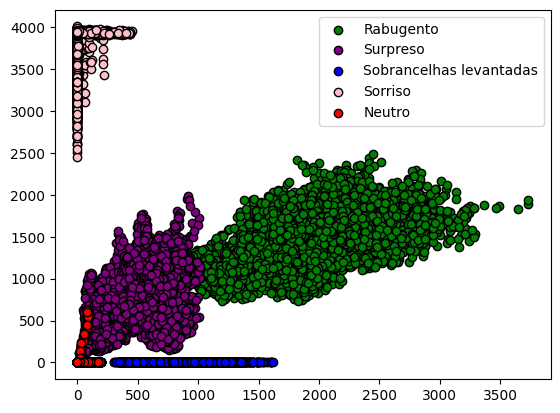

In [16]:
dados = dh("EMGsDataset.csv").dados
# classe 1
# Plotando os dados com categorias e cores correspondentes
plt.scatter(dados[dados[:, 2] == 5, 0], dados[dados[:, 2] == 5, 1], c="green", edgecolor="black", label="Rabugento")
plt.scatter(dados[dados[:, 2] == 4, 0], dados[dados[:, 2] == 4, 1], c="purple", edgecolor="black", label="Surpreso")
plt.scatter(dados[dados[:, 2] == 3, 0], dados[dados[:, 2] == 3, 1], c="blue", edgecolor="black", label="Sobrancelhas levantadas")
plt.scatter(dados[dados[:, 2] == 2, 0], dados[dados[:, 2] == 2, 1], c="pink", edgecolor="black", label="Sorriso")
plt.scatter(dados[dados[:, 2] == 1, 0], dados[dados[:, 2] == 1, 1], c="red", edgecolor="black", label="Neutro")

# Exibindo a legenda e o gráfico
plt.legend()
plt.show()


## Gerar testes

Realizar 500 rodadas para cada algoritmo, analizando a qualidade de suas predições.
Pra o classificador Gaussiano Regularizado, valor de lambda igual a 0 é considerado o modelo Gaussiano Tradicional.
Para valor de lambda igual a 1, o modelo é considerado usando Matriz de covariância agregado

In [3]:
# Armazenar dados 

# lista de lambdas para teste
lmbdas = [0.25, 0.5, 0.75]
title = "Classificador Gaussiano Regularizado (Friedman λ = {lmbda})"


dados_ = {
    "MQO tradicional": [],
    "Classificador Gaussiano Tradicional":[],
    "Classificador Gaussiano (Cov. de todo cj. treino)":[],
    "Classificador Gaussiano (Cov. Agregada)":[],
    "Classificador de Bayes Ingenuo (Naive Bayes Classifier)":[],
}
for i in lmbdas:
    dados_[title.format(lmbda = i)] = []

In [4]:
# mqo tradicional
def MAOtradicional(x_treino, y_treino, x_teste, y_teste):
    y_teste = np.argmax(y_teste.T, axis=1) + 1
    modelo = MQOT(x_treino.T, y_treino.T)
    modelo.trainModel()
    predict = modelo.predict(x_teste.T)

    # avaliar resposta
    aval = predict.flatten() - y_teste.flatten()
    accuracy  = len(aval[aval == 0])/ len(y_teste.flatten())
    return accuracy

# Classificador tradicional Gaussiano
def GaussianoTradicional(x_treino, y_treino, x_test, y_test):
    modelo = GTM(x_treino, y_treino, np.array([1,2,3,4,5]))
    modelo.getStatistcs()
    predict = modelo.predict(x_test)

    # avaliar resposta
    aval = predict- y_test.flatten()
    accuracy  = len(aval[aval == 0])/ len(y_test.flatten())
    return accuracy

def GaussianoCovariancia(x_treino, y_treino, x_test, y_test):
    modelo = GCM(x_treino, y_treino, np.array([1,2,3,4,5]))
    modelo.getStatistcs()
    predict = modelo.predict(x_test)

    # avaliar resposta
    aval = predict- y_test.flatten()
    accuracy  = len(aval[aval == 0])/ len(y_test.flatten())
    return accuracy

def GaussianoAgregado(x_treino, y_treino, x_test, y_test):
    modelo = GGM(x_treino, y_treino, np.array([1,2,3,4,5]))
    modelo.getStatistcs()
    predict = modelo.predict(x_test)

    # avaliar resposta
    aval = predict- y_test.flatten()
    accuracy  = len(aval[aval == 0])/ len(y_test.flatten())
    return accuracy

def GaussianoNaive(x_treino, y_treino, x_test, y_test):
    modelo = GNB(x_treino, y_treino, np.array([1,2,3,4,5]))
    modelo.getStatistcs()
    predict = modelo.predict(x_test)

    # avaliar resposta
    aval = predict- y_test.flatten()
    accuracy  = len(aval[aval == 0])/ len(y_test.flatten())
    return accuracy

def GaussianoRegular(x_treino, y_treino, x_test, y_test, lmbda):
    modelo = GFM(x_treino, y_treino,np.array([1,2,3,4,5]),  lmbda)
    modelo.getStatistcs()
    predict = modelo.predict(x_test)

    # avaliar resposta
    aval = predict- y_test.flatten()
    accuracy  = len(aval[aval == 0])/ len(y_test.flatten())
    return accuracy  


In [5]:
# 500 rodadas
import json


# pegar dados
data_handler = gdh("EMGsDataset.csv")
x1, y1 = data_handler.x, data_handler.y
data_handler.setMatrizes()
x2, y2 = data_handler.x, data_handler.y
y2 = gdh.yAsMatrix(y2)
x2, y2 = x2.T, y2.T
count = 0
for i in range(500):
    print(f"Rodada {i}...")
    count += 1
    if count == 10:
        count = 0
        clear_output()
    # separa dados para treino e teste
    x_treino, y_treino, x_test, y_test = MC.partition2(x1, y1)
    x_treino2, y_treino2, x_test2, y_test2 = MC.partition2(x2, y2)
    
    dados_["MQO tradicional"].append(MAOtradicional(x_treino2, y_treino2, x_test2, y_test2))
    dados_["Classificador Gaussiano Tradicional"].append(GaussianoTradicional(x_treino, y_treino, x_test, y_test))
    dados_["Classificador Gaussiano (Cov. de todo cj. treino)"].append(GaussianoCovariancia(x_treino, y_treino, x_test, y_test))
    dados_["Classificador Gaussiano (Cov. Agregada)"].append(GaussianoAgregado(x_treino, y_treino, x_test, y_test))
    dados_["Classificador de Bayes Ingenuo (Naive Bayes Classifier)"].append(GaussianoNaive(x_treino, y_treino, x_test, y_test))

    for lamb in lmbdas:
        dados_[title.format(lmbda = lamb)].append(GaussianoRegular(x_treino, y_treino, x_test, y_test, lamb))

with open('meu_dicionario.json', 'w') as arquivo:
    json.dump(dados_, arquivo)

In [6]:
import json

# Caminho para o arquivo JSON
file_path = 'meu_dicionario.json'

# Carregar o JSON
with open(file_path, 'r') as file:
    dados:dict = json.load(file)


In [7]:
# gera tabela
header = ["Modelos", "Média", "Desvio Padrão", "Maior Valor", "Menor Valor"]
tabel = {i:[] for i in header}
tabel["Modelos"] = list(dados.keys())


In [8]:
# media
for modelo in dados.keys():
    tabel["Média"].append(np.mean(dados[modelo]))
    tabel["Desvio Padrão"].append(np.std(dados[modelo]))
    tabel["Maior Valor"].append(np.max(dados[modelo]))
    tabel["Menor Valor"].append(np.min(dados[modelo]))

In [9]:
for i, j in tabel.items():
    print(f"{i} : {len(j)}")

Modelos : 8
Média : 8
Desvio Padrão : 8
Maior Valor : 8
Menor Valor : 8


In [10]:

# Exibir a tabela
for i in range(len(tabel["Modelos"])):
    print(f"{tabel['Modelos'][i]:<25} Média: {tabel['Média'][i]:.2f} | "
          f"Desvio Padrão: {tabel['Desvio Padrão'][i]:.2f} | Maior Valor: {tabel['Maior Valor'][i]:.2f} | "
          f"Menor Valor: {tabel['Menor Valor'][i]:.2f}")

MQO tradicional           Média: 0.72 | Desvio Padrão: 0.01 | Maior Valor: 0.74 | Menor Valor: 0.70
Classificador Gaussiano Tradicional Média: 0.20 | Desvio Padrão: 0.00 | Maior Valor: 0.21 | Menor Valor: 0.19
Classificador Gaussiano (Cov. de todo cj. treino) Média: 0.95 | Desvio Padrão: 0.00 | Maior Valor: 0.95 | Menor Valor: 0.94
Classificador Gaussiano (Cov. Agregada) Média: 0.96 | Desvio Padrão: 0.00 | Maior Valor: 0.97 | Menor Valor: 0.96
Classificador de Bayes Ingenuo (Naive Bayes Classifier) Média: 0.95 | Desvio Padrão: 0.00 | Maior Valor: 0.95 | Menor Valor: 0.94
Classificador Gaussiano Regularizado (Friedman λ = 0.25) Média: 0.97 | Desvio Padrão: 0.00 | Maior Valor: 0.98 | Menor Valor: 0.97
Classificador Gaussiano Regularizado (Friedman λ = 0.5) Média: 0.97 | Desvio Padrão: 0.00 | Maior Valor: 0.97 | Menor Valor: 0.96
Classificador Gaussiano Regularizado (Friedman λ = 0.75) Média: 0.96 | Desvio Padrão: 0.00 | Maior Valor: 0.97 | Menor Valor: 0.96


In [11]:
import pandas as pd
from IPython.display import display, HTML

# Configuração para evitar quebra de linha
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Criar e exibir o DataFrame
df_results = pd.DataFrame(tabel)

# Adiciona estilo para alinhar a tabela à esquerda
html_table = df_results.to_html(index=False, justify='left', border=0)


display(HTML(html_table))

Modelos,Média,Desvio Padrão,Maior Valor,Menor Valor
MQO tradicional,0.723686,0.006349,0.7431,0.7021
Classificador Gaussiano Tradicional,0.199892,0.003634,0.2104,0.1891
Classificador Gaussiano (Cov. de todo cj. treino),0.948281,0.001984,0.9539,0.9425
Classificador Gaussiano (Cov. Agregada),0.962453,0.001774,0.9672,0.9571
Classificador de Bayes Ingenuo (Naive Bayes Classifier),0.947196,0.002030,0.9530,0.9408
Classificador Gaussiano Regularizado (Friedman λ = 0.25),0.974782,0.001463,0.9794,0.9693
Classificador Gaussiano Regularizado (Friedman λ = 0.5),0.967938,0.001616,0.9729,0.9633
Classificador Gaussiano Regularizado (Friedman λ = 0.75),0.964778,0.001699,0.9692,0.9600


In [12]:
df_results.to_csv("resultados_modelos.csv", index=False)